## Figure 2 Properties of local PCs and discovery of pcQTLs


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import upsetplot as up
import ast
from tqdm.auto import tqdm 
tqdm.pandas()

# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *

# set higher figure resolution (for poster)
import matplotlib as mpl
#mpl.rcParams['figure.dpi']= 1000

# make a palette
tissue_ids = load_tissue_ids(config)
tissue_pal = sns.color_palette('blend:#B83A4B,#FEC51D,#67AFD2', n_colors=len(tissue_ids))

### a) var explained by pcs

In [ ]:
def load_pc_annotated(config, tissue_id):
    return pd.read_csv("{}{}/{}.v8.pcs_annotated.txt".format(config["annotations_output_dir"], tissue_id, tissue_id), sep='\t')

pc_annotated = load_across_tissues(config, load_pc_annotated)

# remove clusters with high cross map
clusters_annotated = load_across_tissues(config, load_clusters_annotated)
cross_map_ids = clusters_annotated[clusters_annotated['has_cross_map']]['cluster_id']
clusters_annotated = remove_cross_map(clusters_annotated, cross_map_ids)
pc_annotated = remove_cross_map(pc_annotated, cross_map_ids)

In [8]:
# get the top two egene variances per pc
pc_annotated_largest = pc_annotated.groupby(["pc_phenotype_id", "tissue_id", "pc_id", "cluster_size"])['egene_r2'].apply(lambda x: x.nlargest(2).tolist()).reset_index()
pc_annotated_largest['egene_r2_1'] = pc_annotated_largest['egene_r2'].str[0] * 100
pc_annotated_largest['egene_r2_2'] = pc_annotated_largest['egene_r2'].str[1] * 100

# add pc order tags
pc_annotated_largest['phenotype_id'] = pc_annotated_largest['pc_phenotype_id']
annotate_pc_order(pc_annotated_largest)

# cutoff for if a pc passes
pc_cutoff = 10

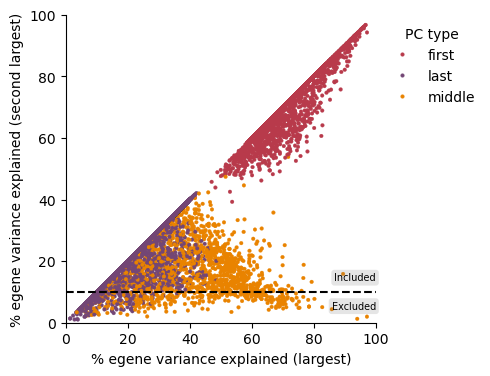

In [26]:
# make the plot
# on the line are cluster size 2, off line are larger clusters

fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(pc_annotated_largest, x='egene_r2_1', y='egene_r2_2', hue="pc_order", s=7, edgecolor=None, ax=ax,
                palette={'first':'#B83A4B', 'middle':'#E98300', 'last':'#734675'})

# Set labels
ax.set_xlabel('% egene variance explained (largest)')
ax.set_ylabel('% egene variance explained (second largest)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0,100)
ax.set_ylim(0,100)
ax.hlines(pc_cutoff, 0, 100, color='k', linestyle='--')
# Add labels above and below the dotted line
ax.text(100, pc_cutoff + 3, 'Included', ha='right', va='bottom', fontsize=7, 
        bbox=dict(facecolor='grey', edgecolor='none', boxstyle='round,pad=0.3', alpha=.2))

ax.text(100, pc_cutoff - 3, 'Excluded', ha='right', va='top', fontsize=7, 
        bbox=dict(facecolor='grey', edgecolor='none', boxstyle='round,pad=0.3', alpha=.2))



# Show the plot
ax.legend(title='PC type', frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### b) discovery of pcQTLS

In [ ]:
# load in data for all tissues 
pc_susie = load_across_tissues(config, load_pc_susie)
pc_susie = remove_cross_map(pc_susie, cross_map_ids)

# get total number of clusters and genes in clusters
pcqtl_counts = pc_susie.groupby('tissue_id').agg({'cs_id':'nunique'})

# add in sample sizes
sample_sizes = pd.read_csv(config['gtex_meta'], sep='\t')
pcqtl_counts = pd.merge(pcqtl_counts, sample_sizes, on='tissue_id')

/local/scratch/klawren/slrmtmp.47327205/ipykernel_32057/3813117735.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


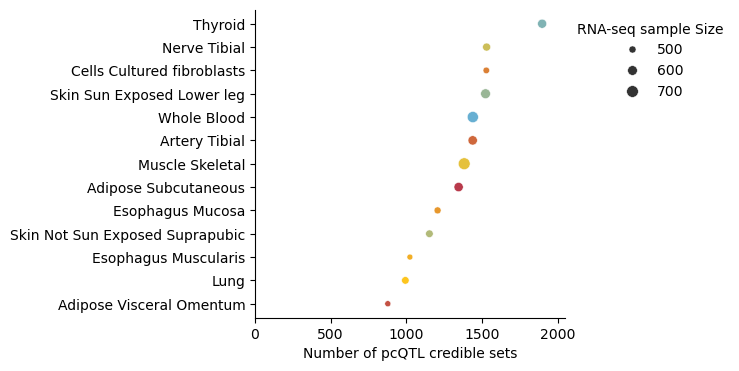

In [103]:
# make the plot
fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(pcqtl_counts.sort_values('cs_id', ascending=False), x='cs_id', y='tissue_id', hue='tissue_id', palette=tissue_pal, size='sample_size', ax=ax, hue_order=tissue_ids)

# Keep only sample_size legend entries
handles, labels = ax.get_legend_handles_labels()
new_handles = []
new_labels = []
for handle, label in zip(handles, labels):
    if label.isnumeric():  # Assuming sample_size will be numeric and thus its labels will be numerical
        new_handles.append(handle)
        new_labels.append(label)
ax.legend(new_handles[::2], new_labels[::2], title='RNA-seq sample Size', frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Number of pcQTL credible sets')
ax.set_ylabel('')

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)
ax.set_xlim((0, ax.get_xlim()[1]+100))

plt.show()

### c) per cluster discovery of pcQTLS

In [59]:
underlying_signals = load_across_tissues(config, load_signal_groups)
underlying_signals = remove_cross_map(underlying_signals, config=config)

In [112]:
# has to be on underlying signals so we don't count clusters with a 1 and 2 credible set on the same signal as having two signls
pc_underlying_signals = underlying_signals[underlying_signals['num_pc_coloc'] > 0]
pcqtls_per_cluster = pc_underlying_signals.groupby(['tissue_id', 'cluster_id']).agg({'signal_id':'nunique'}).reset_index()
pcqtls_per_cluster = pd.merge(clusters_annotated[['cluster_id', 'tissue_id']], pcqtls_per_cluster, how='left', on=['cluster_id', 'tissue_id'])
pcqtls_per_cluster['n_genes'] = pcqtls_per_cluster['cluster_id'].str.split('_').apply(len)
pcqtls_per_cluster['cs_id'] = pcqtls_per_cluster['signal_id'].fillna(0)
pcqtls_per_cluster['has_pcqtl'] = pcqtls_per_cluster['signal_id'] > 0
pcqtls_per_cluster['has_2_pcqtl'] = pcqtls_per_cluster['signal_id'] > 1
pcqtls_per_cluster['has_3_pcqtl'] = pcqtls_per_cluster['signal_id'] > 2
pcqtls_per_cluster['has_4_pcqtl'] = pcqtls_per_cluster['signal_id'] > 3


# get the fraction of clusters with a pcqtl
fraction_with_pcqtl = pcqtls_per_cluster.groupby('tissue_id').agg({'cluster_id':'nunique', 'has_pcqtl':'mean', 'has_2_pcqtl':'mean',  'has_3_pcqtl':'mean', 'has_4_pcqtl':'mean'})
# add in sample sizes
fraction_with_pcqtl = pd.merge(fraction_with_pcqtl, sample_sizes, on='tissue_id')

/local/scratch/klawren/slrmtmp.47327205/ipykernel_32057/549887419.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


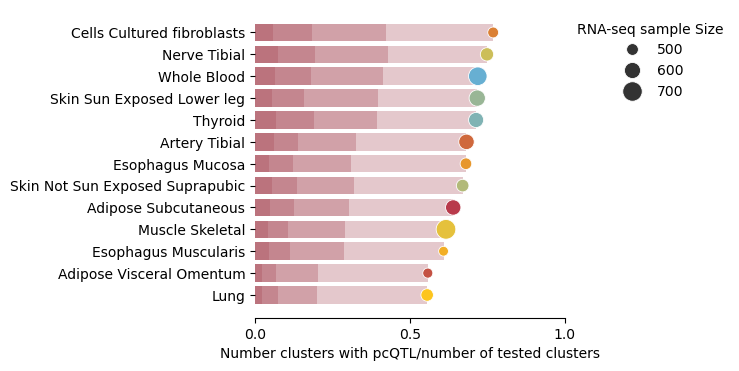

In [119]:
# make the plot
fig, ax = plt.subplots(figsize=(4,4))
sns.barplot(fraction_with_pcqtl.sort_values('has_pcqtl', ascending=False), x='has_pcqtl', y='tissue_id', color='#B83A4B', ax=ax, hue_order=tissue_ids, alpha=.3, width=.8)
sns.barplot(fraction_with_pcqtl.sort_values('has_pcqtl', ascending=False), x='has_2_pcqtl', y='tissue_id', color='#B83A4B', ax=ax, hue_order=tissue_ids, alpha=.3, width=.8)
sns.barplot(fraction_with_pcqtl.sort_values('has_pcqtl', ascending=False), x='has_3_pcqtl', y='tissue_id', color='#B83A4B', ax=ax, hue_order=tissue_ids, alpha=.3, width=.8)
sns.barplot(fraction_with_pcqtl.sort_values('has_pcqtl', ascending=False), x='has_4_pcqtl', y='tissue_id', color='#B83A4B', ax=ax, hue_order=tissue_ids, alpha=.3, width=.8)


sns.scatterplot(fraction_with_pcqtl.sort_values('has_pcqtl', ascending=False), x='has_pcqtl', y='tissue_id', hue='tissue_id', palette=tissue_pal, size='sample_size', ax=ax, hue_order=tissue_ids, sizes=(50,200))
# sns.scatterplot(fraction_with_pcqtl.sort_values('has_pcqtl', ascending=False), x='has_2_pcqtl', y='tissue_id', hue='tissue_id', palette=tissue_pal, size='sample_size', ax=ax, hue_order=tissue_ids, legend=False, sizes=(50,200))
# sns.scatterplot(fraction_with_pcqtl.sort_values('has_pcqtl', ascending=False), x='has_3_pcqtl', y='tissue_id', hue='tissue_id', palette=tissue_pal, size='sample_size', ax=ax, hue_order=tissue_ids, legend=False, sizes=(50,200))
# sns.scatterplot(fraction_with_pcqtl.sort_values('has_pcqtl', ascending=False), x='has_4_pcqtl', y='tissue_id', hue='tissue_id', palette=tissue_pal, size='sample_size', ax=ax, hue_order=tissue_ids, legend=False, sizes=(50,200))


# Keep only sample_size legend entries
handles, labels = ax.get_legend_handles_labels()
new_handles = []
new_labels = []
for handle, label in zip(handles, labels):
    if label.isnumeric():  # Assuming sample_size will be numeric and thus its labels will be numerical
        new_handles.append(handle)
        new_labels.append(label)
ax.legend(new_handles[::2], new_labels[::2], title='RNA-seq sample Size', frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Number clusters with pcQTL/number of tested clusters')
ax.set_ylabel('')

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)
ax.set_xlim([0,1])
ax.set_xticks([0, .5, 1])

plt.show()

### Supp: per cluster, how many pcs pass cutoff?

/local/scratch/klawren/slrmtmp.47327205/ipykernel_32057/599154815.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tissue_labels)


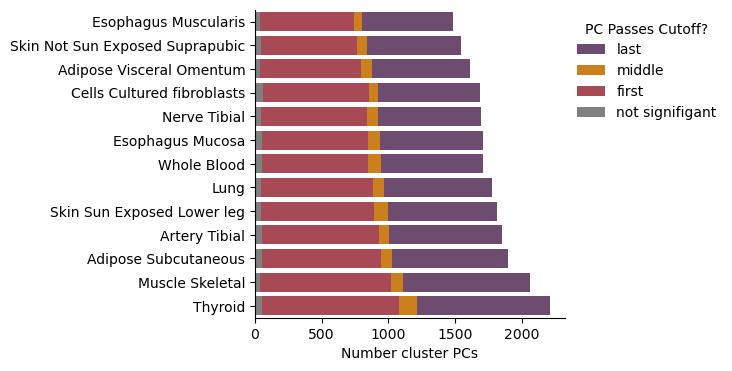

In [28]:
# set the cutoff to 10%
pc_annotated_largest['pc_passes_cutoff'] = pc_annotated_largest['egene_r2_2'] > pc_cutoff
pc_annotated_largest.loc[~pc_annotated_largest['pc_passes_cutoff'],'pc_order']="didnt_pass"


# group by tissue and, count the number that pass and the total number
pc_passed_cutoff = pc_annotated_largest.groupby(['tissue_id', 'pc_order']).size().reset_index()

fig, ax = plt.subplots(figsize=(4,4))
tissue_order = pc_annotated_largest.groupby(['tissue_id']).size().sort_values().index.values

# start with the all pcs, colored for last
sns.barplot(pc_passed_cutoff, y='tissue_id', x=0, ax=ax, color='#734675', label='last', estimator=sum, errorbar=None, order=tissue_order)
# add in the middle and first pcs, colored for middle
sns.barplot(pc_passed_cutoff[pc_passed_cutoff['pc_order'].isin(['middle', 'first', 'didnt_pass'])], ax=ax, y='tissue_id', x=0, color='#E98300', label='middle', estimator=sum, errorbar=None)
# add in the first pcs, colored for first
sns.barplot(pc_passed_cutoff[pc_passed_cutoff['pc_order'].isin(['first', 'didnt_pass'])], ax=ax, y='tissue_id', x=0, color='#B83A4B', label='first', estimator=sum, errorbar=None)
# add in the didnt pass pcs, colored grey
sns.barplot(pc_passed_cutoff[pc_passed_cutoff['pc_order'].isin(['didnt_pass'])], ax=ax, y='tissue_id', x=0, color='grey', label="not signifigant", estimator=sum, errorbar=None)


# Create the legend in a separate location
ax.legend(title="PC Passes Cutoff?", loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

# Set labels
ax.set_xlabel('Number cluster PCs')
ax.set_ylabel('')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Replace underscores with spaces in the tissue labels
tissue_labels = ax.get_yticklabels()
tissue_labels = [tissue_label.get_text().replace('_', ' ') for tissue_label in tissue_labels]
ax.set_yticklabels(tissue_labels)

plt.show()


### supp pcqtls in removed pcs

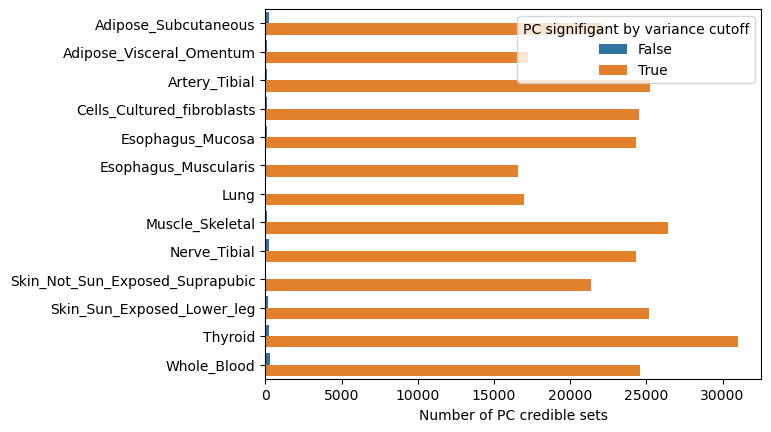

In [30]:
# aside: confirm most pcqtl credible sets are in a pc that passes cutoffs
pc_susie['pc_passes_cutoff'] = pc_susie['phenotype_id'].isin(pc_annotated_largest[pc_annotated_largest['egene_r2_2'] > 10]['pc_phenotype_id'])

ax = sns.countplot(pc_susie, y='tissue_id', hue='pc_passes_cutoff')
ax.set_xlabel("Number of PC credible sets")
ax.set_ylabel("")
# Change legend title
leg = ax.get_legend()
leg.set_title('PC signifigant by variance cutoff')